# setting up 

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import glob

import tarfile
import zipfile
import copy
import pandas as pd
import seaborn as sns
import datetime

from FaceDetectorOpenCV import *
# working_dir = 'C:/Users/101ma/Documents/emotion-recognition-transferlearning/'
working_dir = 'D:/Mandy/emotion-recognition-transferlearning/'

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img, img_to_array

from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization,GlobalAveragePooling2D
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint,TensorBoard
from keras.optimizers import RMSprop, Adam, Adagrad

Using TensorFlow backend.


# load and show test images

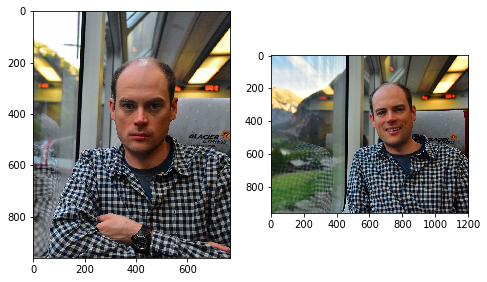

In [2]:
test_dir = 'data/test_pics'
test_list = sorted(glob.glob(os.path.join(working_dir,test_dir,'*')))
test_images = []
for file in test_list:
    test_images.append(np.array(Image.open(file)))

#show the images
show_image_num = 2 # how many images to show
plt.figure(0, figsize = (10, 8))
for image_id, image in enumerate(test_images[:show_image_num]):
    plt.subplot(1, len(test_images)+1, image_id+1)
    plt.imshow(image, cmap='gray')
plt.tight_layout()
plt.show()

# detect and crop faces

Face 0 dimension is: (200, 200, 3)
Face 1 dimension is: (200, 200, 3)


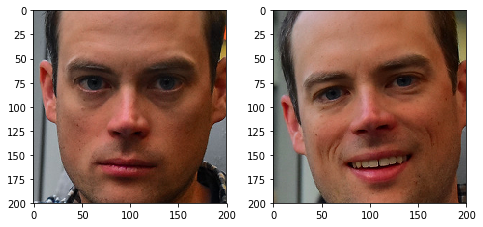

In [3]:
detector = FaceDetector(working_dir + "haarcascade_frontalface_default.xml")

# the width and height of the output face; could be set to (48,48)
resized_shape = (200,200)

# Could try 0.5 to see the effect
zoom_ratio = 0

cropped_faces = []
for image_id, image in enumerate(test_images):
    faces_coord = detector.detect(image, True)
    faces = normalize_faces(image ,faces_coord,resized_shape,zoom_ratio)
    for face in faces:
        cropped_faces.append(face)

# show the cropped faces
#show the images
plt.figure(0, figsize = (10, 8))
for face_id, face in enumerate(cropped_faces):
    plt.subplot(1, len(cropped_faces)+1, face_id+1)
    plt.imshow(face, cmap='gray')
    print('Face ' + str(face_id) + ' dimension is: ' + str(face.shape))
plt.tight_layout()
plt.show()
    

# setting up training data for EmoNet

In [4]:
#extract the tar file
tar_dir = tarfile.open(working_dir + 'data/fer2013.tar.gz', 'r:gz')
tar_dir.extractall(working_dir+ 'data/')

#dataset from kaggle challege read into a pandas dataframe
images_df = pd.read_csv(working_dir + 'data/fer2013/fer2013.csv')

#make a emotion dict that relates the emotion number with the expression
emotion_dict = {0: 'Angry', 1:'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6:'Neutral'}
#see some descriptive statistics
images_df['emotion'].value_counts().rename(emotion_dict)

Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Disgust      547
Name: emotion, dtype: int64

In [5]:
#Setting up the training data
train_df = images_df[images_df['Usage'] == 'Training'][['emotion', 'pixels']]
train_df['pixels'] = train_df['pixels'].apply(lambda im: np.fromstring(im, sep=' '))

#df without 0s
index_0s = [i for i, x in enumerate(train_df['pixels']) if np.sum(x) == 0]
train_df = train_df[~train_df.index.isin(index_0s)].reset_index(drop = True)

x_train = np.vstack(train_df['pixels'].values)
y_train = np.array(train_df['emotion'])
print ('x_train shape is: ', x_train.shape)
print ('y_train shape is: ', y_train.shape)

x_train shape is:  (28698, 2304)
y_train shape is:  (28698,)


In [6]:
#Setting up the public test data
public_test_df = images_df[images_df['Usage'] == 'PublicTest'][['emotion', 'pixels']]
public_test_df["pixels"] = public_test_df["pixels"].apply(lambda im: np.fromstring(im, sep=' '))
x_public_test = np.vstack(public_test_df['pixels'].values)
y_public_test = np.array(public_test_df['emotion'])
print('x_public_test shape is: ', x_public_test.shape)
print('y_public_test shape is: ', y_public_test.shape)

x_public_test shape is:  (3589, 2304)
y_public_test shape is:  (3589,)


In [7]:
#resahpe images to a 48 x 48 pixel matrix
#we need to flatten it to one channel though which is what the 1 at the 
#end does
x_train = x_train.reshape(-1, 48, 48, 1)
x_public_test = x_public_test.reshape(-1, 48, 48, 1)
print ('x_train new shape is: ', x_train.shape)
print ('x_test new shape is: ', x_public_test.shape)

x_train new shape is:  (28698, 48, 48, 1)
x_test new shape is:  (3589, 48, 48, 1)


In [8]:
def to_rgb(image, input_shape):
    resized_image = cv2.resize(image, (input_shape[0],input_shape[1]), interpolation=cv2.INTER_CUBIC)
    img_rgb = np.stack((resized_image,)*3, axis=-1)
    return img_rgb

input_shape = [224,224];
x_train_resized = np.zeros((x_train.shape[0],input_shape[0],input_shape[1],3))
x_public_test_resized = np.zeros((x_public_test.shape[0],input_shape[0],input_shape[1],3))
for image_id in np.arange(x_train.shape[0]):
    x_train_resized[image_id,:,:,:] = to_rgb(x_train[image_id,:,:,0],input_shape)
for image_id in np.arange(x_public_test.shape[0]):
    x_public_test_resized[image_id,:,:,:] = to_rgb(x_public_test[image_id,:,:,0],input_shape)
print ('x_train new shape is: ', x_train_resized.shape)
print ('x_test new shape is: ', x_public_test_resized.shape)

x_train new shape is:  (28698, 224, 224, 3)
x_test new shape is:  (3589, 224, 224, 3)


In [9]:
#Make y categorical
y_train_cat= pd.get_dummies(y_train).as_matrix()
y_public_test_cat = pd.get_dummies(y_public_test).as_matrix()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


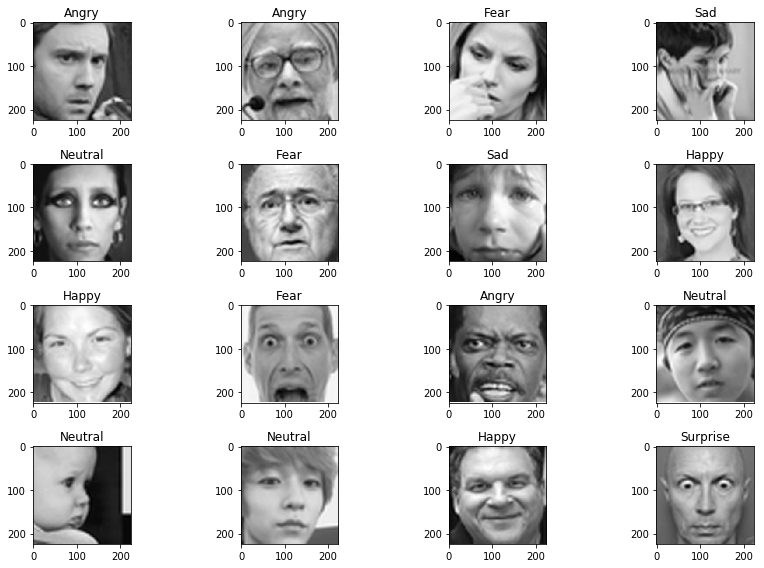

In [10]:
#show some images
plt.figure(0, figsize = (12, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_train_resized[i, :, :, 0], cmap='gray')
    plt.title(emotion_dict[np.where(y_train_cat[i] == 1)[0][0]])
plt.tight_layout()
plt.show()

# set up EmoNet

This is the part where we will branch out and write our own code.

## for feature extraction

In [11]:
from keras_vggface.vggface import VGGFace
vggface = VGGFace(model='resnet50', include_top=False, input_shape = (224,224,3))

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
vggface.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_1[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
__________________________________________________________________________________________________
max_poolin

In [22]:
# add a few layers on top
vggface.trainable = False
model = Sequential([
    vggface, 
    Flatten(), 
    Dense(1024, activation='relu'),
    Dense(256, activation='relu'),
    Dense(len(emotion_dict), activation='softmax', name = 'classifer')])

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Model)     (None, 1, 1, 2048)        23561152  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 256)               262400    
_________________________________________________________________
classifer (Dense)            (None, 7)                 1799      
Total params: 25,923,527
Trainable params: 2,362,375
Non-trainable params: 23,561,152
_________________________________________________________________


In [24]:
model.compile(optimizer = Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### train the model

In [25]:
#runs the model specified
#train data follos format [x, y].  Same with val_data
def run_model(model, model_name, epochs, train_data, val_data, batch_size):
    # save best weights
    log_dir="logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    checkpointer = ModelCheckpoint(filepath=working_dir + 'checkpoints/' + '%s.h5'%model_name, verbose=1)
    tensorboard_callback = TensorBoard(log_dir=log_dir)

    # run model
    history = model.fit(train_data[0], train_data[1], epochs=epochs,
                   shuffle=True,
                   batch_size=batch_size, validation_data=(val_data[0], val_data[1]),
                   callbacks=[checkpointer,tensorboard_callback], verbose=2)
    return history

#saves model to json file saves model weights to h5 file
def save_model(model, model_name, working_dir):

    # save model to json
    model_json = model.to_json()
    with open(working_dir + 'models/' + "%s.json"%model_name, "w") as json_file:
        json_file.write(model_json)

    #save model weights
    #save weights
    model.save_weights(working_dir +'models/' + '%s_weights.h5'%model_name)

In [26]:
# # #run and train model
history = run_model(model, 'model_vggFace', 20, [x_train_resized, y_train_cat], [x_public_test_resized, y_public_test_cat], 40)
save_model(model, 'model_vggFace', working_dir)

Train on 28698 samples, validate on 3589 samples
Epoch 1/20
 - 67s - loss: 1.2958 - acc: 0.5307 - val_loss: 1.2824 - val_acc: 0.5525

Epoch 00001: saving model to D:/Mandy/emotion-recognition-transferlearning/checkpoints/model_vggFace.h5
Epoch 2/20
 - 66s - loss: 0.9212 - acc: 0.6665 - val_loss: 1.2866 - val_acc: 0.5659

Epoch 00002: saving model to D:/Mandy/emotion-recognition-transferlearning/checkpoints/model_vggFace.h5
Epoch 3/20
 - 66s - loss: 0.7381 - acc: 0.7352 - val_loss: 1.3380 - val_acc: 0.5584

Epoch 00003: saving model to D:/Mandy/emotion-recognition-transferlearning/checkpoints/model_vggFace.h5
Epoch 4/20
 - 66s - loss: 0.5750 - acc: 0.8001 - val_loss: 1.3552 - val_acc: 0.5642

Epoch 00004: saving model to D:/Mandy/emotion-recognition-transferlearning/checkpoints/model_vggFace.h5
Epoch 5/20
 - 66s - loss: 0.4459 - acc: 0.8548 - val_loss: 1.4231 - val_acc: 0.5603

Epoch 00005: saving model to D:/Mandy/emotion-recognition-transferlearning/checkpoints/model_vggFace.h5
Epoch 

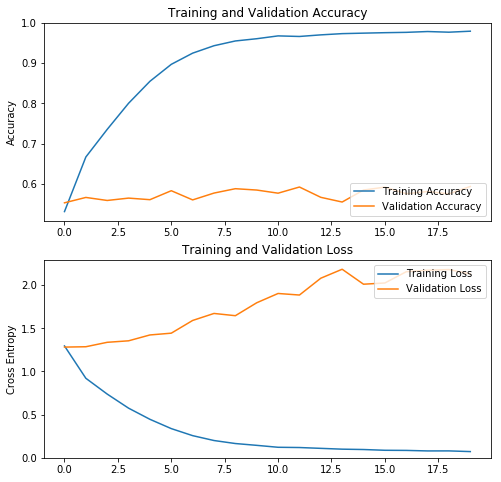

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

## for fine tuning